# GAN
0. [Import modules](#Import-modules)
1. [Load and prepare image dataset](#Load-&-prepare-image-dataset)
2. [Create models: generator & discriminator](#Create-models)
3. [Define loss & optimizers](#Discriminator-loss)
4. [Train & save models](#Train-&-save-models)
5. [Track progress on tensorboard](#Track-progress-on-tensorboard)
6. [Reload models & generate fake image](#Reload-models-&-generate-fake-image)

## Import modules

In [2]:
# import tensorflow as tf
import tensorflow.compat.v2 as tf

tf.enable_v2_behavior()

from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

#from tensorflow.python.compiler.mlcompute import mlcompute
# mlcompute.set_mlc_device(device_name='gpu')

In [2]:
# from tensorflow.python.compiler.mlcompute import mlcompute
# mlcompute.set_mlc_device(device_name='gpu')
# tf.config.run_functions_eagerly(False)

In [3]:
# modules to handle files
from pathlib import Path
import os.path

# module to prepare data and train model
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# module to plot 
from matplotlib import pyplot as plt

In [4]:
import os
import glob
import time
from IPython import display

import PIL
import imageio

import numpy as np

## Load & prepare image dataset

In [5]:
# get dataset directory
# train_data_dir = Path("../assets/datasets/birds/birds_100x100")
train_data_dir = Path("../assets/datasets/kaggle_birds/birds_rev2/train")
train_data_dir

PosixPath('../assets/datasets/kaggle_birds/birds_rev2/train')

In [6]:
# CONSTANTS
IMG_WIDTH = 100
IMG_HEIGHT = 100
BATCH_SIZE = 9

In [7]:
# create image data augmentation generator
train_datagen = ImageDataGenerator(
                                   # rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True
                                  )
# create iterator
train_iterator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH), # resize to (height, width)
    batch_size= BATCH_SIZE,
    color_mode="grayscale"
)

Found 39364 images belonging to 275 classes.


### plot 1 generated batch of images

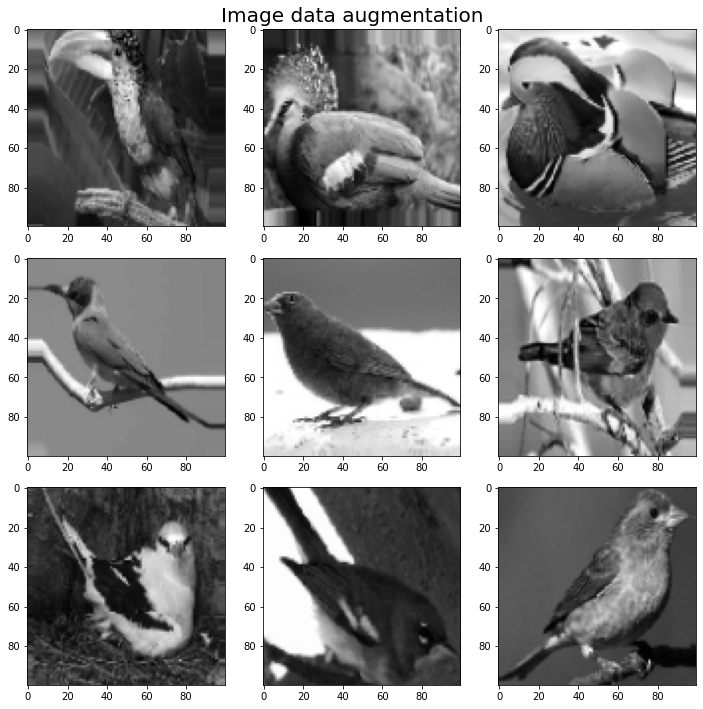

In [8]:
# set subplots grid
len_rows = 3
len_cols = 3
fig, ax = plt.subplots(BATCH_SIZE//len_rows,len_cols, figsize=(10,10))

# generate samples and plot
for i in range(BATCH_SIZE):
    
    # define subplot
    ax_i=ax[i//len_rows,i - len_cols*(i//len_cols)]
    
    # generate batch of images
    batch = train_iterator.next()
    
    # convert to unsigned integers for viewing
    # img = (batch[0][1]*255).astype('uint8')
    img = batch[0][1].astype('uint8')
    
    # plot raw pixel data
    ax_i.imshow(img, cmap="gray")

# show the figure
fig.suptitle('Image data augmentation', fontsize=20)
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

## Create models

### Create generator

In [9]:
def make_generator_model(img_height, img_width):
    """
    Function to create a generator model
    with Keras Sequential API.
    
    """
    # instantiate sequential model
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(25*25*256, use_bias=False, input_shape=(100,)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    
    model.add(tf.keras.layers.Reshape((25,25,256)))
    assert model.output_shape == (None,25,25,256) # None is the batch size
    
    model.add(tf.keras.layers.Conv2DTranspose(128, (5,5), strides=(1,1), padding="same", use_bias=False))
    assert model.output_shape == (None,25,25,128)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    
    model.add(tf.keras.layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding="same", use_bias=False))
    assert model.output_shape == (None,50,50,64)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    
    model.add(tf.keras.layers.Conv2DTranspose(1, (5,5), strides=(2,2), padding="same", use_bias=False, activation="tanh"))
    assert model.output_shape == (None, img_height, img_width, 1)
    
    return model
    

### create an image with the initial generator (not yet trained)

In [14]:
# create generator instance
generator = make_generator_model(IMG_HEIGHT, IMG_WIDTH)

# input noise into model to generate an image
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(tf.make_ndarray(generated_image[0]), cmap="gray")

SyntaxError: invalid syntax (199502384.py, line 17)

### Create discriminator

In [10]:
def make_discriminator_model(img_height, img_width):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(64, (5,5), strides=(2,2), padding="same", input_shape=[img_height, img_width,1]))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))
    
    model.add(tf.keras.layers.Conv2D(128, (5,5), strides=(2,2), padding="same"))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))
    
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1))
    
    return model

### classify an image with the initial discriminator (not yet trained):
if model outputs 
- positive values: real
- negative values: fake

In [11]:
discriminator = make_discriminator_model(IMG_HEIGHT, IMG_WIDTH)
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.0008951]], shape=(1, 1), dtype=float32)


## Define loss and optimizers

In [12]:
# get helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Generator loss
quantifies how well generator fool discriminator. A good generator should make the discriminator classify fake images as real (1):
- compares discriminator's predictions on fake images to an array of 1s.

In [13]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

### Discriminator loss
quantifies how well discriminator classify real and fake images:
- compares discriminator's predictions on real images to an array of 1s (as the discriminator outputs need to go close to 1)
- compares discriminator's predictions on fake images to an array of 0s (as the discriminator outputs need to go close to 0)

In [14]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Optimizers
different discriminator and generator optimizers as we train the 2 networks separately.

In [15]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## Train & save models

### Save checkpoints

In [16]:
checkpoint_dir = "./training_checkpoints"
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    generator=generator,
    discriminator=discriminator
                                )

In [17]:
def generate_and_save_images(model, epoch, test_input):
    # predict
    ## training = False to make all layers run in inference mode (batchnorm)
    predictions = model(test_input, training=False)
    
    fig = plt.figure(figsize=(4,4))
    for i in range(predictions.shape[0]):
        plt.subplot(4,4,i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap="gray")
        plt.axis("off")
        
    plt.savefig(f"image_at_epoch_{epoch:04d}.png") # e.g. image_at_epoch_0001.png
    plt.show()

### Training loop
1. generator receives random seed as input
2. generator produce an image
3. discriminator classifies real images (from training set) and fake images (from generator)
4. calcul loss for each model
5. get gradients 
6. use gradients to update generator and discriminator with optimizer

In [18]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# seed to visualize progress in animated GIF
seed = tf.random.normal([num_examples_to_generate, noise_dim])

#### Functions

In [19]:
@tf.function # decorator to compile the function
def train_step(real_images):
    # create random seed
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    # track gradients
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        
        # 1. 2. generate image from noise as input
        generated_images = generator(noise, training=True)
        
        # 3. classify real images & fake images
        real_output = discriminator(real_images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        # 4. compute generator loss & discriminator loss
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
        # 5. get gradients of generator & discriminator
        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        
        # 6. use gradients to update generator & discriminator
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
        
        

In [20]:
# def train(dataset, epochs):
def train(train_iterator, epochs):
    for epoch in range(epochs):
        start_time = time.time()
        
        #for image_batch in dataset:
       #     train_step(image_batch)
        # generate batch of images
        
        for i in range(9):
            image_batch = train_iterator.next()
            train_step(image_batch[0])
            
        # produces images for the GIF
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)
        
        # save model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
        
        end_time = time.time()
        runtime_s = end_time - start_time
        print(f"time for epoch {epoch + 1}: {runtime_s} sec")
        
    # generate image after final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

#### Train
>Call the train() method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

>At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits. This may take about one minute / epoch with the default settings on Colab.

In [ ]:
# train(train_dataset, EPOCHS)
train(train_iterator, EPOCHS)

2021-07-11 10:20:52.653252: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-07-11 10:20:52.657745: W tensorflow/core/platform/profile_utils/cpu_utils.cc:126] Failed to get CPU frequency: 0 Hz


## Track progress on tensorboard

## Reload models & generate fake image

In [1]:
import numpy as np
import tensorflow as tf

### Aman's code to enable the GPU
from tensorflow.python.compiler.mlcompute import mlcompute
tf.compat.v1.disable_eager_execution()
mlcompute.set_mlc_device(device_name='gpu')
print("is_apple_mlc_enabled %s" % mlcompute.is_apple_mlc_enabled())
print("is_tf_compiled_with_apple_mlc %s" % mlcompute.is_tf_compiled_with_apple_mlc())
print(f"eagerly? {tf.executing_eagerly()}")
print(tf.config.list_logical_devices())

x = np.random.random((10000, 5))
y = np.random.random((10000, 2))

x2 = np.random.random((2000, 5))
y2 = np.random.random((2000, 2))

inp = tf.keras.layers.Input(shape = (5,))
l1 = tf.keras.layers.Dense(256, activation = 'sigmoid')(inp)
l1 = tf.keras.layers.Dense(256, activation = 'sigmoid')(l1)
l1 = tf.keras.layers.Dense(256, activation = 'sigmoid')(l1)
l1 = tf.keras.layers.Dense(256, activation = 'sigmoid')(l1)
l1 = tf.keras.layers.Dense(256, activation = 'sigmoid')(l1)
o = tf.keras.layers.Dense(2, activation = 'sigmoid')(l1)

model = tf.keras.models.Model(inputs = [inp], outputs = [o])
model.compile(optimizer = "Adam", loss = "mse")

model.fit(x, y, validation_data = (x2, y2), batch_size = 500, epochs = 500)


is_apple_mlc_enabled True
is_tf_compiled_with_apple_mlc True
eagerly? False
[LogicalDevice(name='/device:CPU:0', device_type='CPU')]
Train on 10000 samples, validate on 2000 samples
Epoch 1/500


2021-07-10 17:40:58.612077: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:196] None of the MLIR optimization passes are enabled (registered 0 passes)
2021-07-10 17:40:58.614413: W tensorflow/core/platform/profile_utils/cpu_utils.cc:126] Failed to get CPU frequency: 0 Hz


10000/10000 [==============================] - 1s 98us/sample - loss: 0.0846 - val_loss: 0.0845
Epoch 2/500
 1500/10000 [===>..........................] - ETA: 0s - loss: 0.0827

/Users/derrickvanfrausum/anaconda3/envs/apple_tensorflow/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


10000/10000 [==============================] - 1s 74us/sample - loss: 0.0831 - val_loss: 0.0842
Epoch 3/500
10000/10000 [==============================] - 1s 71us/sample - loss: 0.0827 - val_loss: 0.0845
Epoch 4/500
10000/10000 [==============================] - 1s 70us/sample - loss: 0.0831 - val_loss: 0.0849
Epoch 5/500
10000/10000 [==============================] - 1s 70us/sample - loss: 0.0828 - val_loss: 0.0841
Epoch 6/500
10000/10000 [==============================] - 1s 70us/sample - loss: 0.0826 - val_loss: 0.0842
Epoch 7/500
10000/10000 [==============================] - 1s 71us/sample - loss: 0.0826 - val_loss: 0.0843
Epoch 8/500
10000/10000 [==============================] - 1s 71us/sample - loss: 0.0829 - val_loss: 0.0840
Epoch 9/500
10000/10000 [==============================] - 1s 75us/sample - loss: 0.0831 - val_loss: 0.0840
Epoch 10/500
10000/10000 [==============================] - 1s 72us/sample - loss: 0.0829 - val_loss: 0.0840
Epoch 11/500


KeyboardInterrupt: 